# Improved ANN Churn Model Training
## Fixes:
1. Class imbalance handling with class weights
2. Better model architecture
3. More comprehensive evaluation metrics
4. Dropout for regularization

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import datetime

In [2]:
# Load the dataset
data = pd.read_csv('Churn_Modeling.csv')
print(f"Dataset shape: {data.shape}")
print(f"\nChurn distribution:")
print(data['Exited'].value_counts())
print(f"\nChurn rate: {data['Exited'].mean()*100:.2f}%")
data.head()

Dataset shape: (10000, 14)

Churn distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64

Churn rate: 20.37%


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Preprocess the data by dropping irrelevant features
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Encode categorical variables - Gender
label_encoder_gender = LabelEncoder()
data['Gender'] = label_encoder_gender.fit_transform(data['Gender'])
print(f"Gender encoding: {dict(zip(label_encoder_gender.classes_, label_encoder_gender.transform(label_encoder_gender.classes_)))}")
data.head()

Gender encoding: {'Female': np.int64(0), 'Male': np.int64(1)}


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# One-hot encode Geography
ohe_geo = OneHotEncoder(sparse_output=False)
geo_encoder = ohe_geo.fit_transform(data[['Geography']])
print(f"Geography columns: {ohe_geo.get_feature_names_out(['Geography'])}")
geo_encoded_df = pd.DataFrame(geo_encoder, columns=ohe_geo.get_feature_names_out(['Geography']))
geo_encoded_df.head()

Geography columns: ['Geography_France' 'Geography_Germany' 'Geography_Spain']


,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [6]:
# Combine the OHE columns with the original data
data = pd.concat([data.drop('Geography', axis=1), geo_encoded_df], axis=1)
print(f"\nFinal columns: {list(data.columns)}")
data.head()


Final columns: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France', 'Geography_Germany', 'Geography_Spain']


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [7]:
# Save the encoders
with open('label_encoder_gender.pkl', 'wb') as file:
    pickle.dump(label_encoder_gender, file)

with open('ohe_geo.pkl', 'wb') as file:
    pickle.dump(ohe_geo, file)
    
print("Encoders saved!")

Encoders saved!


In [8]:
# Divide the dataset into independent and dependent features
X = data.drop("Exited", axis=1)
y = data["Exited"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

Features shape: (10000, 12)
Target shape: (10000,)
Feature columns: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain']


In [9]:
# Divide the data into training and testing segments
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set - X: {X_train.shape}, y: {y_train.shape}")
print(f"Test set - X: {X_test.shape}, y: {y_test.shape}")
print(f"\nTraining set churn rate: {y_train.mean()*100:.2f}%")
print(f"Test set churn rate: {y_test.mean()*100:.2f}%")

Training set - X: (8000, 12), y: (8000,)
Test set - X: (2000, 12), y: (2000,)

Training set churn rate: 20.38%
Test set churn rate: 20.35%


In [10]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape after scaling: {X_train_scaled.shape}")
print(f"Test data shape after scaling: {X_test_scaled.shape}")

Training data shape after scaling: (8000, 12)
Test data shape after scaling: (2000, 12)


In [11]:
# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
print("Scaler saved!")

Scaler saved!


In [12]:
# CRITICAL: Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")
print(f"This will penalize the model more for misclassifying churners!")

Class weights: {0: np.float64(0.6279434850863422), 1: np.float64(2.4539877300613497)}
This will penalize the model more for misclassifying churners!


In [13]:
# Build improved ANN model with dropout for regularization
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()

c:\Users\Sam Ben-Yosef\Desktop\ANN\annvenv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model with additional metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
print("Model compiled with metrics: accuracy, precision, recall, AUC")

Model compiled with metrics: accuracy, precision, recall, AUC


In [15]:
# Set up callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_churn_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

print("Callbacks configured!")

Callbacks configured!


In [16]:
# Train the model WITH CLASS WEIGHTS
history = model.fit(
    X_train_scaled, 
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,  # THIS IS CRITICAL!
    callbacks=[early_stopping, tensorboard_callback, model_checkpoint],
    verbose=1
)

Epoch 1/100
183/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5838 - auc: 0.6399 - loss: 0.6571 - precision: 0.2750 - recall: 0.6188
Epoch 1: val_auc improved from None to 0.78454, saving model to best_churn_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6562 - auc: 0.7113 - loss: 0.6229 - precision: 0.3279 - recall: 0.6473 - val_accuracy: 0.7075 - val_auc: 0.7845 - val_loss: 0.5834 - val_precision: 0.3810 - val_recall: 0.7406
Epoch 2/100
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7119 - auc: 0.7802 - loss: 0.5685 - precision: 0.3930 - recall: 0.7135
Epoch 2: val_auc improved from 0.78454 to 0.82013, saving model to best_churn_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7164 - auc: 0.7844 - loss: 0.5638 - precision: 0.3948 - recall: 0.7237 - val_accuracy: 0.7212 - val_auc: 0.8201 - val_loss: 0.5359 - val_precision: 0.3964 - val_recall: 0.7531
Epoch 3/100
183/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7271 - auc: 0.8058 - loss: 0.5317 - precision: 0.3967 - recall: 0.7199
Epoch 3: val_auc improved from 0.82013 to 0.84488, saving model to best_churn_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7250 - auc: 0.8082 - loss: 0.5353 - precision: 0.4052 - recall: 0.7344 - val_accuracy: 0.7431 - val_auc: 0.8449 - val_loss: 0.5094 - val_precision: 0.4230 - val_recall: 0.7812
Epoch 4/100
182/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7524 - auc: 0.8275 - loss: 0.5085 - precision: 0.4330 - recall: 0.7521
Epoch 4: val_auc improved from 0.84488 to 0.85994, saving model to best_churn_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7567 - auc: 0.8281 - loss: 0.5117 - precision: 0.4436 - recall: 0.7412 - val_accuracy: 0.7775 - val_auc: 0.8599 - val_loss: 0.4623 - val_precision: 0.4651 - val_recall: 0.7500
Epoch 5/100
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7522 - auc: 0.8165 - loss: 0.5196 - precision: 0.4346 - recall: 0.7296
Epoch 5: val_auc did not improve from 0.85994
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7625 - auc: 0.8321 - loss: 0.5031 - precision: 0.4517 - recall: 0.7504 - val_accuracy: 0.8238 - val_auc: 0.8558 - val_loss: 0.3995 - val_precision: 0.5482 - val_recall: 0.6750
Epoch 6/100
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7762 - auc: 0.8265 - loss: 0.5159 - precision: 0.4669 - recall: 0.7139
Epoch 6: val_auc improved from 0.85994 to 0.86127, saving model to best_churn_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7705 - auc: 0.8362 - loss: 0.5014 - precision: 0.4621 - recall: 0.7405 - val_accuracy: 0.8087 - val_auc: 0.8613 - val_loss: 0.4379 - val_precision: 0.5153 - val_recall: 0.7375
Epoch 7/100
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7889 - auc: 0.8453 - loss: 0.4836 - precision: 0.4842 - recall: 0.7496
Epoch 7: val_auc improved from 0.86127 to 0.86344, saving model to best_churn_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7831 - auc: 0.8465 - loss: 0.4866 - precision: 0.4811 - recall: 0.7573 - val_accuracy: 0.7987 - val_auc: 0.8634 - val_loss: 0.4448 - val_precision: 0.4979 - val_recall: 0.7500
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7830 - auc: 0.8471 - loss: 0.4826 - precision: 0.4729 - recall: 0.7301
Epoch 8: val_auc did not improve from 0.86344
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7759 - auc: 0.8439 - loss: 0.4899 - precision: 0.4699 - recall: 0.7397 - val_accuracy: 0.7837 - val_auc: 0.8634 - val_loss: 0.4723 - val_precision: 0.4756 - val_recall: 0.7906
Epoch 9/100
187/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7876 - auc: 0.8593 - loss: 0.4673 - precision: 0.4826 - recall: 0.7613
Epoch 9: val_auc did not improve from 0.86344
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7820 - auc: 0.8522 - loss: 0.4790 - precision: 0.4793 - recall: 0.7519 - val_accuracy: 0.8094 - val_auc: 0.8621 - v

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7886 - auc: 0.8491 - loss: 0.4835 - precision: 0.4892 - recall: 0.7405 - val_accuracy: 0.8087 - val_auc: 0.8637 - val_loss: 0.4399 - val_precision: 0.5150 - val_recall: 0.7500
Epoch 11/100
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7878 - auc: 0.8544 - loss: 0.4772 - precision: 0.4909 - recall: 0.7541
Epoch 11: val_auc improved from 0.86369 to 0.86492, saving model to best_churn_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7903 - auc: 0.8552 - loss: 0.4753 - precision: 0.4920 - recall: 0.7504 - val_accuracy: 0.8175 - val_auc: 0.8649 - val_loss: 0.4119 - val_precision: 0.5315 - val_recall: 0.7375
Epoch 12/100
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7907 - auc: 0.8661 - loss: 0.4577 - precision: 0.4952 - recall: 0.7691
Epoch 12: val_auc did not improve from 0.86492
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7852 - auc: 0.8565 - loss: 0.4707 - precision: 0.4842 - recall: 0.7580 - val_accuracy: 0.7850 - val_auc: 0.8624 - val_loss: 0.4530 - val_precision: 0.4765 - val_recall: 0.7594
Epoch 13/100
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7755 - auc: 0.8549 - loss: 0.4873 - precision: 0.4889 - recall: 0.7694
Epoch 13: val_auc did not improve from 0.86492
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7877 - auc: 0.8580 - loss: 0.4698 - precision: 0.4881 - recall: 0.7672 - val_accuracy: 0.8012 - val_auc: 0.8629

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7942 - auc: 0.8604 - loss: 0.4661 - precision: 0.4983 - recall: 0.7618 - val_accuracy: 0.8025 - val_auc: 0.8653 - val_loss: 0.4226 - val_precision: 0.5042 - val_recall: 0.7563
Epoch 17/100
184/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7948 - auc: 0.8579 - loss: 0.4619 - precision: 0.4881 - recall: 0.7649
Epoch 17: val_auc did not improve from 0.86527
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7898 - auc: 0.8604 - loss: 0.4644 - precision: 0.4914 - recall: 0.7634 - val_accuracy: 0.7956 - val_auc: 0.8614 - val_loss: 0.4468 - val_precision: 0.4930 - val_recall: 0.7719
Epoch 18/100
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7948 - auc: 0.8705 - loss: 0.4533 - precision: 0.5045 - recall: 0.7749
Epoch 18: val_auc improved from 0.86527 to 0.86593, saving model to best_churn_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7864 - auc: 0.8614 - loss: 0.4627 - precision: 0.4861 - recall: 0.7618 - val_accuracy: 0.8006 - val_auc: 0.8659 - val_loss: 0.4386 - val_precision: 0.5010 - val_recall: 0.7688
Epoch 19/100
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7813 - auc: 0.8634 - loss: 0.4676 - precision: 0.4909 - recall: 0.7621
Epoch 19: val_auc did not improve from 0.86593
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7855 - auc: 0.8634 - loss: 0.4632 - precision: 0.4847 - recall: 0.7641 - val_accuracy: 0.8156 - val_auc: 0.8653 - val_loss: 0.4117 - val_precision: 0.5281 - val_recall: 0.7344
Epoch 20/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7965 - auc: 0.8657 - loss: 0.4528 - precision: 0.4972 - recall: 0.7756
Epoch 20: val_auc did not improve from 0.86593
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7877 - auc: 0.8628 - loss: 0.4608 - precision: 0.4882 - recall: 0.7733 - val_accuracy: 0.8050 - val_auc: 0.8647

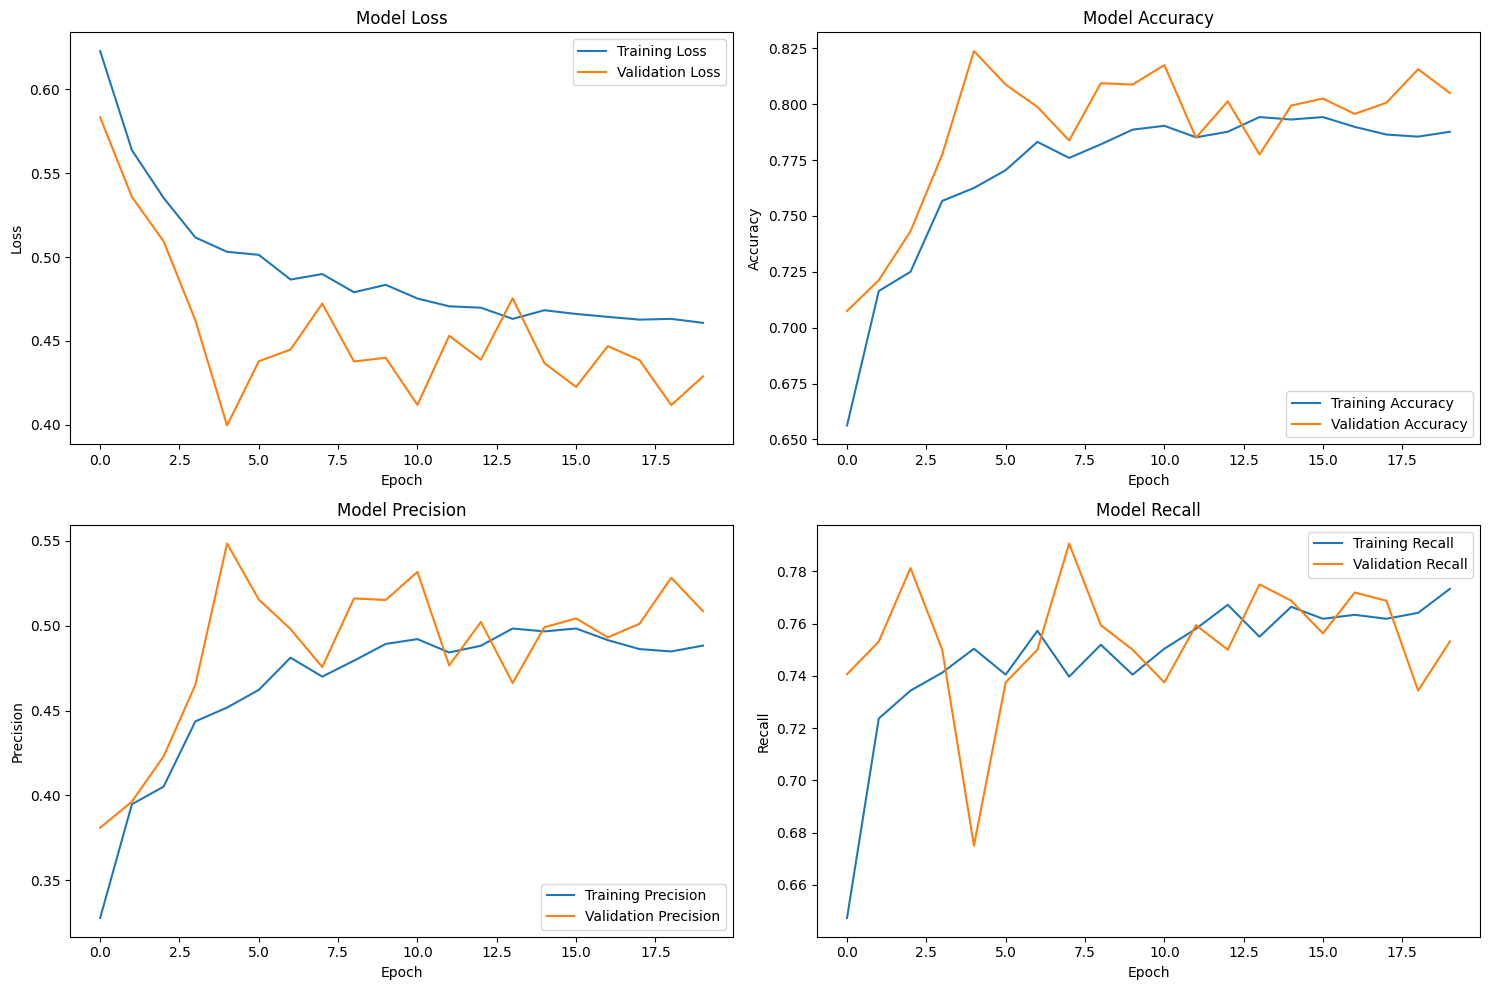

In [17]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [18]:
# Evaluate on test set
test_results = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"\nTest Results:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")
print(f"AUC: {test_results[4]:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8150 - auc: 0.8500 - loss: 0.4107 - precision: 0.5361 - recall: 0.6757 

Test Results:
Loss: 0.4107
Accuracy: 0.8150
Precision: 0.5361
Recall: 0.6757
AUC: 0.8500


In [19]:
# Make predictions and analyze
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.91      0.85      0.88      1593
     Churned       0.54      0.68      0.60       407

    accuracy                           0.81      2000
   macro avg       0.72      0.76      0.74      2000
weighted avg       0.83      0.81      0.82      2000


Confusion Matrix:
[[1355  238]
 [ 132  275]]

True Negatives: 1355
False Positives: 238
False Negatives: 132
True Positives: 275


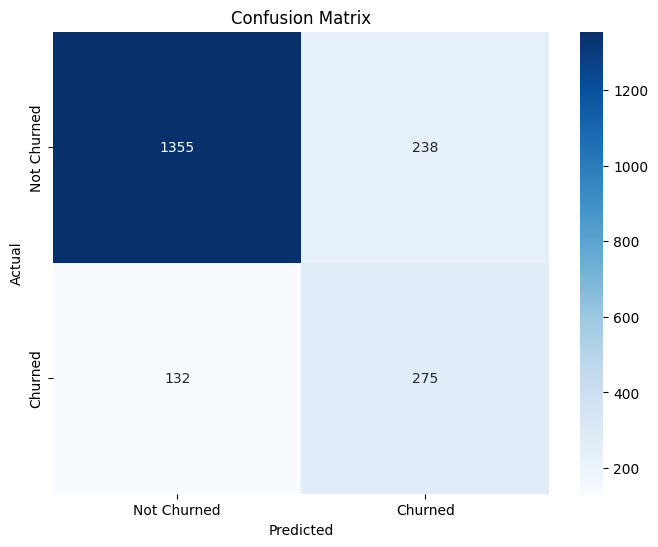

In [21]:
# Plot confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')
plt.show()

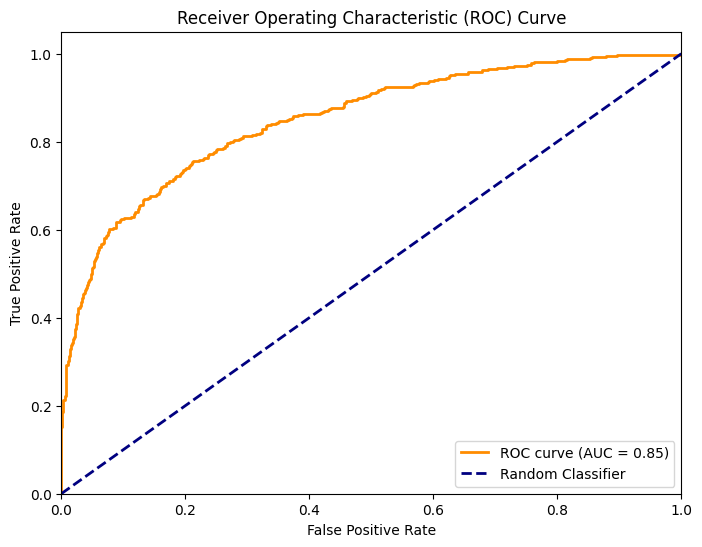

In [22]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

In [23]:
# Test with risky customer profile
print("Testing with HIGH RISK customer profile:")
risky_customer = pd.DataFrame({
    "CreditScore": [500],
    "Gender": [0],  # Female
    "Age": [35],
    "Tenure": [0],
    "Balance": [120],
    "NumOfProducts": [1],
    "HasCrCard": [0],
    "IsActiveMember": [0],
    "EstimatedSalary": [20000],
    "Geography_France": [1.0],
    "Geography_Germany": [0.0],
    "Geography_Spain": [0.0]
})

risky_scaled = scaler.transform(risky_customer)
risky_pred = model.predict(risky_scaled)[0][0]
print(f"Churn probability: {risky_pred:.4f}")
print(f"Expected: HIGH (>0.5)")

print("\nTesting with LOW RISK customer profile:")
safe_customer = pd.DataFrame({
    "CreditScore": [800],
    "Gender": [1],  # Male
    "Age": [40],
    "Tenure": [10],
    "Balance": [150000],
    "NumOfProducts": [2],
    "HasCrCard": [1],
    "IsActiveMember": [1],
    "EstimatedSalary": [100000],
    "Geography_France": [1.0],
    "Geography_Germany": [0.0],
    "Geography_Spain": [0.0]
})

safe_scaled = scaler.transform(safe_customer)
safe_pred = model.predict(safe_scaled)[0][0]
print(f"Churn probability: {safe_pred:.4f}")
print(f"Expected: LOW (<0.5)")

Testing with HIGH RISK customer profile:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Churn probability: 0.3647
Expected: HIGH (>0.5)

Testing with LOW RISK customer profile:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Churn probability: 0.1145
Expected: LOW (<0.5)


In [24]:
# Save the final model
model.save('churn_model_improved.h5')
print("\nImproved model saved as 'churn_model_improved.h5'")
print("\nTo use in your Streamlit app, rename it to 'churn_model.h5' or update the app.py to load 'churn_model_improved.h5'")


Improved model saved as 'churn_model_improved.h5'

To use in your Streamlit app, rename it to 'churn_model.h5' or update the app.py to load 'churn_model_improved.h5'
